In [9]:
from PIL import Image
import numpy as np
import math
from matplotlib import pyplot as plt
import time
import json
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from tqdm import tqdm
from pathlib import Path
import cv2

In [2]:
import torch
from torchsummary import summary

In [3]:
DATASET_NAME = "Squares_new_2"

In [4]:
class HuiNet(torch.nn.Module):
    def __init__(self):
        super(HuiNet, self).__init__()
        self.layers_indexes = dict()
        self.conv_lays = [1, 16]
        counter = 0
        self.layers_list = []

        num_convs = 1
        num_fc = 10

        for i in range(num_convs):
            self.layers_list.append(torch.nn.Conv2d(in_channels=self.conv_lays[i], out_channels=self.conv_lays[
                i + 1], kernel_size=16, padding=8, stride=2))
            self.layers_indexes["cv" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.ReLU())
            self.layers_indexes["act" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.MaxPool2d(kernel_size=4, stride=4))
            self.layers_indexes["pool" + str(i + 1)] = counter
            counter += 1

        self.layers_list.append(torch.nn.Linear(16*32*32, 100))
        self.layers_indexes['fc1'] = counter
        counter += 1
        self.layers_list.append(torch.nn.ReLU())
        self.layers_indexes[f'act{num_convs + 1}'] = counter
        counter += 1
    
        for i in range(1, num_fc):
            if i == num_fc-1:
                self.layers_list.append(torch.nn.Linear(100, 2))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
            else:
                self.layers_list.append(torch.nn.Linear(100, 100))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
                self.layers_list.append(torch.nn.ReLU())
                self.layers_indexes[f"act{i+num_convs + 2}"] = counter
                counter += 1
        self.layers_list = torch.nn.ModuleList(self.layers_list)

    def forward(self, x):
        for key in self.layers_indexes:
            if key == "fc1":
                x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
            x = self.layers_list[self.layers_indexes[key]](x)
        return x


FOLDER_FOR_NETWORKS_EPOCH = "states_30.08.22_try1_side"
Path(f"States/{FOLDER_FOR_NETWORKS_EPOCH}").mkdir(parents=True, exist_ok=True)

huinet = HuiNet()

start_epoch = 16

if start_epoch != 1:
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch-1}.txt"))
    huinet.eval()
else:
    dictForJson = dict()
    for key in huinet.layers_indexes.keys():
        dictForJson[key] = str(huinet.layers_list[huinet.layers_indexes[key]])
    with open(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/0_model_description", "w") as outfile:
        json.dump(dictForJson, outfile)
        
huinet.float()


HuiNet(
  (layers_list): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(16, 16), stride=(2, 2), padding=(8, 8))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Linear(in_features=16384, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=100, bias=True)
    (16): ReLU()
    (17): Linear(in_features=100, out_features=100, bias=True)
    (18): ReLU()
    (19): Linear(in_features=100, out_features=100, bias=True)
    (20): ReLU()
    (21): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
huinet = huinet.to(device)
device

device(type='cuda', index=0)

In [6]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(huinet.parameters(), lr=1.0e-3)

In [7]:
f = open(f"Datasets/{DATASET_NAME}/labels.txt")
f = f.readlines()
N = len(f)
print(N)
N_test = math.floor(0.98 * N)

X_test = torch.zeros((N - N_test, 1, 256, 256))
y_test = torch.zeros(N - N_test, 2)

for i in range(N_test, N):
    name, label = f[i].split()
    label = torch.tensor(list(map(int, label.split("_")[:2])))
    y_test[i - N_test] += label
    img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
    X_test[i - N_test] += torch.tensor(np.asarray(img)).resize(3, 256, 256)[0, :]

50000


/home/youbot/.local/lib/python3.8/site-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [8]:
batch_size = 16
N_epochs = 1000

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
tb = SummaryWriter()

norm =  torch.tensor([255, 255]).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

for epoch in range(N_epochs):
    order = np.random.permutation(N_test)
    current_losses = []
    time_start = time.time()
    
    for start_index in tqdm(range(0, N_test, batch_size),leave=False):
        torch.cuda.empty_cache()
        X_train = torch.zeros((batch_size,1,256,256))
        y_train = torch.zeros((batch_size,2))
        for i in range(start_index, start_index + batch_size):
            name, label = f[i].split()
            label = torch.tensor(list(map(int, label.split("_")[:2])))
            y_train[i%batch_size] += label
            img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
            X_train[i%batch_size] += torch.tensor(np.asarray(img)).reshape(3, 256, 256)[0, :]
        optimizer.zero_grad()

        X_batch = X_train.to(device)
        y_batch = y_train.to(device)

        preds = huinet.forward(X_batch)

        loss_value = loss(preds/norm, y_batch/norm)
        current_losses.append(loss_value.item())
        loss_value.backward()
        tb.add_scalar("Batch",loss_value.item(), epoch * N_test//batch_size + start_index//batch_size)

        optimizer.step()
        del X_train, y_train, label
        torch.cuda.empty_cache()

    test_preds = huinet.forward(X_test)
    test_loss_history.append(loss(test_preds/norm, y_test/norm).item())
    # # TODO: новая accuracy когда-нибудь
    # # accuracy = (test_preds.argmax(dim=0) == y_test).float().mean().data.cpu()
    accuracy = np.array(current_losses).mean()
    test_accuracy_history.append(accuracy)
    print(f"Epoch: {epoch+start_epoch}/{start_epoch+N_epochs-1} Accuracy: {accuracy} Time:{time.time()-time_start} Last loss: {test_loss_history[-1]}")
    tb.add_scalar("Accuracy",accuracy, epoch)
    del test_preds, accuracy
    torch.cuda.empty_cache()
    torch.save(huinet.state_dict(), f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch + epoch}.txt")

Epoch: 1/1000 Accuracy: 0.03606069845080843 Time:129.11312556266785 Last loss: 0.024725457653403282


Epoch: 2/1000 Accuracy: 0.02425208396968224 Time:123.98114705085754 Last loss: 0.022341668605804443


Epoch: 3/1000 Accuracy: 0.022506120149502266 Time:123.49678587913513 Last loss: 0.021965060383081436


Epoch: 4/1000 Accuracy: 0.021952277563200364 Time:125.80620121955872 Last loss: 0.021614953875541687


Epoch: 5/1000 Accuracy: 0.02163676920319855 Time:126.3841347694397 Last loss: 0.022258399054408073


Epoch: 6/1000 Accuracy: 0.02134212613243511 Time:125.02294278144836 Last loss: 0.021209223195910454


Epoch: 7/1000 Accuracy: 0.021222947086619565 Time:125.36524486541748 Last loss: 0.021981256082654


Epoch: 8/1000 Accuracy: 0.020924911922931798 Time:126.15121269226074 Last loss: 0.02208167314529419


Epoch: 9/1000 Accuracy: 0.020887958831930672 Time:126.12147426605225 Last loss: 0.022322004660964012


Epoch: 10/1000 Accuracy: 0.020711662262371658 Time:124.52455449104309 Last loss: 0.02136990986764431


Epoch: 11/1000 Accuracy: 0.020939004358477037 Time:126.41538333892822 Last loss: 0.022180862724781036


Epoch: 12/1000 Accuracy: 0.020550769512713993 Time:125.27375268936157 Last loss: 0.02231653966009617


Epoch: 13/1000 Accuracy: 0.02046244072884752 Time:125.52145099639893 Last loss: 0.02251177653670311


Epoch: 14/1000 Accuracy: 0.020438409002830428 Time:124.60500884056091 Last loss: 0.02200241945683956


Epoch: 15/1000 Accuracy: 0.020339606348954205 Time:125.78733015060425 Last loss: 0.02189582958817482


Epoch: 16/1000 Accuracy: 0.020298998724834018 Time:124.93037438392639 Last loss: 0.021821441128849983


KeyboardInterrupt: 

In [12]:
def checkDrawingsForEpoche(epoch, drawing, base_img = None, test=True, color=(255,0,0)):
    huinet = HuiNet()
    huinet.float()
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{epoch}.txt"))
    huinet.eval()
    huinet = huinet.to(device)

    a = huinet.forward(X_test[drawing].reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(-1).tolist()  #prediction
    b = y_test[drawing].cpu().detach().numpy().astype(dtype=int).tolist()  #label

    #original filled with black color
    if base_img is None:
        whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    else:
        whiteblankimage = base_img

    # rect = ((b[0], b[1]), (b[2], b[3]), b[4])
    # box = cv2.boxPoints(rect)
    # box = np.int0(box)
    # cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)
    cv2.circle(whiteblankimage,(b[0],b[1]),15,(0,255,0),thickness=cv2.FILLED)
    cv2.circle(whiteblankimage,(a[0],a[1]),10,(255,0,0))
    #red contour of prediction
    # rect = ((a[0], a[1]), (a[2], a[3]), a[4])
    # box = cv2.boxPoints(rect)
    # box = np.int0(box)
    # cv2.drawContours(whiteblankimage,[box],0,color)

    #saving and drawing
    # cv2.imwrite(f'ImagesByEpoch/IM2.0/{drawing}_{epoch}.jpeg' , whiteblankimage)
    return whiteblankimage

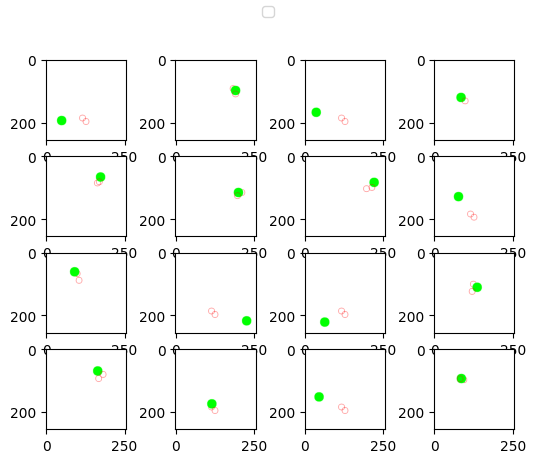

In [13]:
e, d = 15,1
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        # aa = 0
        result = checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j)
        result = checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, base_img=result, color=(0,0,255))
        axs[i][j].imshow(result)
str_ = str(f"red - random blue - {e}")
fig.legend(str_, loc='upper center')
plt.show()